In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
from IPython.display import display
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
#widgets.IntSlider()

In [2]:
#Import Engineered Ames Data
Ames = pd.read_csv('Ames_HousePrice_Engineered.csv')

#Update with new Ames Data
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold', 'Living_Area_%of_Lot', 'Lot_Frontage_%', 'Home_Age',
    'Yrs_Since_Remodel', '1stFlr_%of_Living_Area', 'Interior_Area_%of_Lot', 'Total_Bathrooms_prorated',
    'Kitchens_prorated', 'OverallQual_weighted', 'ExterQual_weighted', 'GarageArea_prorated', 'BsmtArea_prorated'
]].apply(pd.to_numeric, errors='coerce')

Ames_Columns_Ordinal = Ames[[ 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]].apply(pd.to_numeric, errors='coerce')

Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype('category')

#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [3]:
encoder = OneHotEncoder(sparse_output=False)
encoder_nominal = OneHotEncoder(sparse_output=False)
encoder_ordinal = OneHotEncoder(sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

#One-Hot Encode Nominal
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)
#DO NOT One-Hot Encode Ordinal (for now)
Ames_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)
#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)

In [4]:
Y = Ames['SalePrice']
X = Ames_MLR_Optimal_Columns

#Alternate Version with no One Hot Encoding for HistGradient, LightGBM, and CatBoost
X2 = pd.concat([Ames_Columns_Numeric, Ames_Columns_Ordinal, Ames_Columns_Nominal], axis=1)
for col in Ames_Columns_Nominal.columns:
    X2[col] = X2[col].astype('category')
    Ames[col] = Ames[col].astype('category')

In [5]:
def Plot_Feature_SHAP_Importances(model, model_name, X=X, top_n=20, use_all_rows=True, max_estimators=20):
    pd.reset_option("display.float_format")
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    
    #Feature Importances
    importances = None
    if hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'feature_importances_'):
        #Bagging with tree base estimators
        if max_estimators < len(best_model.estimators_):
            selected_estimators = np.random.choice(best_model.estimators_, size=max_estimators, replace=False)
        else:
            selected_estimators = best_model.estimators_
        importances = np.mean([est.feature_importances_ for est in selected_estimators], axis=0)
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif model_name.lower().startswith('cat') and hasattr(best_model, 'get_feature_importance'):
        importances = best_model.get_feature_importance()
    
    if importances is None:
        print(f'{model_name} does not expose native feature importances.')
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.nan})
    else:
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': np.round(importances, 4)
        }).sort_values('Importance', ascending=False)
        
        #Plot Top Feature Importances
        top_features = feature_importance_df.head(top_n)
        plt.figure(figsize=(8,6))
        plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='teal')
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Top {top_n} Feature Importances')
        plt.tight_layout()
        plt.show()
    
    #SHAP Values
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    try:
        # Bagging tree-based models: subsample estimators for SHAP
        if hasattr(best_model, 'estimators_'):
            if max_estimators < len(best_model.estimators_):
                selected_estimators = np.random.choice(best_model.estimators_, size=max_estimators, replace=False)
                temp_model = best_model.__class__(base_estimator=best_model.estimators_[0], n_estimators=max_estimators)
                temp_model.estimators_ = selected_estimators
                explainer = shap.TreeExplainer(temp_model)
            else:
                explainer = shap.TreeExplainer(best_model)
        elif hasattr(best_model, 'tree_') or 'Tree' in str(type(best_model)):
            explainer = shap.TreeExplainer(best_model)
        else:
            explainer = shap.Explainer(best_model, X_sample)
        shap_values = explainer(X_sample)
    except Exception:
        explainer = shap.Explainer(best_model.predict, X_sample)
        shap_values = explainer(X_sample)
    
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    
    shap_value_df = pd.DataFrame({
        'Feature': X_sample.columns,
        '|SHAP value|': shap_abs_mean
    }).sort_values('|SHAP value|', ascending=False)
    
    #Plot Top SHAP values
    top_shap = shap_value_df.head(top_n)
    plt.figure(figsize=(8,6))
    plt.barh(top_shap['Feature'][::-1], top_shap['|SHAP value|'][::-1], color='cornflowerblue')
    plt.xlabel('|SHAP value| (Avg Impact)')
    plt.title(f'{model_name} - Top {top_n} SHAP Feature Values')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.tight_layout()
    plt.show()
    
    #Merge Feature Importance & SHAP
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)
    feature_shap_df_top = feature_shap_df.head(top_n).copy()
    y_pos = np.arange(len(feature_shap_df_top))
    
    #Side by Side Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True)
    
    #Feature Importance subplot
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Feature Importance')
    ax1.set_title(f'{model_name} - Top {top_n} Feature Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    #SHAP values subplot
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='cornflowerblue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - Top {top_n} SHAP Feature Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    plt.tight_layout()
    plt.show()

    #Top 20 Table
    display(feature_shap_df.head(top_n).style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))

In [6]:
def Plot_HGB_Feature_SHAP_Importances(model, X=X, Y=Y, top_n=20, use_all_rows=True, n_permutations=10):
    pd.reset_option("display.float_format")
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    
    #Permutation Feature Importances
    perm_imp = permutation_importance(best_model, X, Y, n_repeats=n_permutations, random_state=2, n_jobs=-1)
    
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_imp.importances_mean
    }).sort_values('Importance', ascending=False)
    
    #Plot Top Permutation Importances
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(8,6))
    plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='teal')
    plt.xlabel('Permutation Importance')
    plt.title(f'HistGradientBoostingRegressor - Top {top_n} Permutation Importances')
    plt.tight_layout()
    plt.show()
    
    # SHAP Values
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(X_sample)
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    
    shap_value_df = pd.DataFrame({
        'Feature': X_sample.columns,
        '|SHAP value|': shap_abs_mean
    }).sort_values('|SHAP value|', ascending=False)
    
    #Plot Top SHAP values
    top_shap = shap_value_df.head(top_n)
    plt.figure(figsize=(8,6))
    plt.barh(top_shap['Feature'][::-1], top_shap['|SHAP value|'][::-1], color='cornflowerblue')
    plt.xlabel('|SHAP value| (Avg Impact)')
    plt.title(f'HistGradientBoostingRegressor - Top {top_n} SHAP Values')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.3f}'))
    plt.tight_layout()
    plt.show()
    
    #Merge Feature Importance & SHAP
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)
    feature_shap_df_top = feature_shap_df.head(top_n).copy()
    y_pos = np.arange(len(feature_shap_df_top))
    
    #Side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True)
    
    #Permutation Importance subplot
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Permutation Importance')
    ax1.set_title(f'HistGradientBoostingRegressor - Top {top_n} Permutation Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.3f}'))
    
    #SHAP Values subplot
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='cornflowerblue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([])
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'HistGradientBoostingRegressor - Top {top_n} SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.3f}'))
    
    plt.tight_layout()
    plt.show()
    
    #Top 20 table
    display(feature_shap_df_top.style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))

In [7]:
#Decision Tree Regressor: Base Model
tree_model = DecisionTreeRegressor(random_state=2)
tree_model.fit(X, Y)
print('Decision Tree Base Model Score:', float(cross_val_score(tree_model, X, Y).mean()))

Decision Tree Base Model Score: 0.7751161154882393


In [8]:
#Hist Gradient Boosting Base Model
hgbm = HistGradientBoostingRegressor(random_state=2, verbose=1,
    categorical_features=[
        X2.columns.get_loc(col) for col in Ames_Columns_Nominal.columns]
)
hgbm.fit(X2, Y)

Binning 0.002 GB of training data: 0.062 s
Fitting gradient boosted rounds:
Fit 100 trees in 2.687 s, (3100 total leaves)
Time spent computing histograms: 0.227s
Time spent finding best splits:  0.105s
Time spent applying splits:      0.112s
Time spent predicting:           0.004s


,loss,'squared_error'
,quantile,None
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,"[68, 69, ...]"


In [9]:
print('HistGradientBoosting Base Model Score:', float(cross_val_score(hgbm, X2, Y).mean()))

Binning 0.002 GB of training data: 0.052 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.539 s, (3100 total leaves)
Time spent computing histograms: 0.169s
Time spent finding best splits:  0.084s
Time spent applying splits:      0.090s
Time spent predicting:           0.006s
Binning 0.002 GB of training data: 0.034 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.397 s, (3100 total leaves)
Time spent computing histograms: 0.119s
Time spent finding best splits:  0.067s
Time spent applying splits:      0.067s
Time spent predicting:           0.003s
Binning 0.002 GB of training data: 0.045 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.380 s, (3100 total leaves)
Time spent computing histograms: 0.105s
Time spent finding best splits:  0.063s
Time spent applying splits:      0.061s
Time spent predicting:           0.003s
Binning 0.002 GB of training data: 0.035 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.410 s, (3100 total leaves)
Time spent computing histograms:

In [11]:
#Initial Hist Gradient Boosting RandomizedSearchCV for faster estimates
hgbm_param = {
    'learning_rate': [0.045, 0.08, .15],
    'max_leaf_nodes': [8, 10, 12],
    'max_iter': [138, 175, 212],
    'min_samples_leaf': [15, 20, 25],
    #'l2_regularization': [0.0, 0.1, 0.5, 1.0],
}
random_search_hgb = RandomizedSearchCV(
    estimator=hgbm,
    param_distributions=hgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_hgb.fit(X2, Y)
print('Best parameters:', random_search_hgb.best_params_)
print(f'Best CV Score: {random_search_hgb.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Binning 0.002 GB of training data: 0.053 s
Fitting gradient boosted rounds:
Fit 175 trees in 0.305 s, (1400 total leaves)
Time spent computing histograms: 0.068s
Time spent finding best splits:  0.057s
Time spent applying splits:      0.043s
Time spent predicting:           0.005s
Best parameters: {'min_samples_leaf': 15, 'max_leaf_nodes': 8, 'max_iter': 175, 'learning_rate': 0.08}
Best CV Score: 0.9238


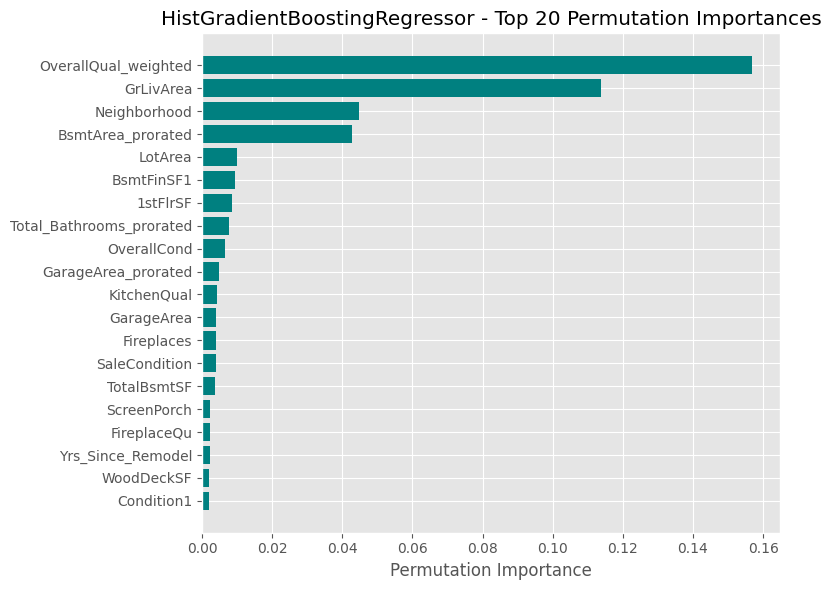

ValueError: could not convert string to float: 'No Alley Access'

In [12]:
#Hist Gradient Boosting Regressor Feature Importances & SHAP values
Plot_HGB_Feature_SHAP_Importances(random_search_hgb, X=X2)

In [13]:
#Base LightGBM Model
lgbm = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1)
lgbm.fit(X2, Y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5667
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 87
[LightGBM] [Info] Start training from score 178053.442420


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [14]:
print('LightGBM Base Model Score:', float(cross_val_score(lgbm, X2, Y).mean()))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5570
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 87
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5584
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 87
[LightGBM] [Info] Start training from score 177182.857974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5576
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 87
[LightGBM] [Info] St

In [15]:
#Initial LightGBM RandomizedSearchCV for faster estimates
lgbm_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [1, 50, 99],
    'n_estimators': range(150, 250),
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5]
}
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm.fit(X2, Y)
print('Best parameters:', random_search_lgbm.best_params_)
print(f'Best CV Score: {random_search_lgbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5669
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 88
[LightGBM] [Info] Start training from score 178053.442420
Best parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 243, 'min_child_samples': 10, 'max_depth': 99, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best CV Score: 0.9210


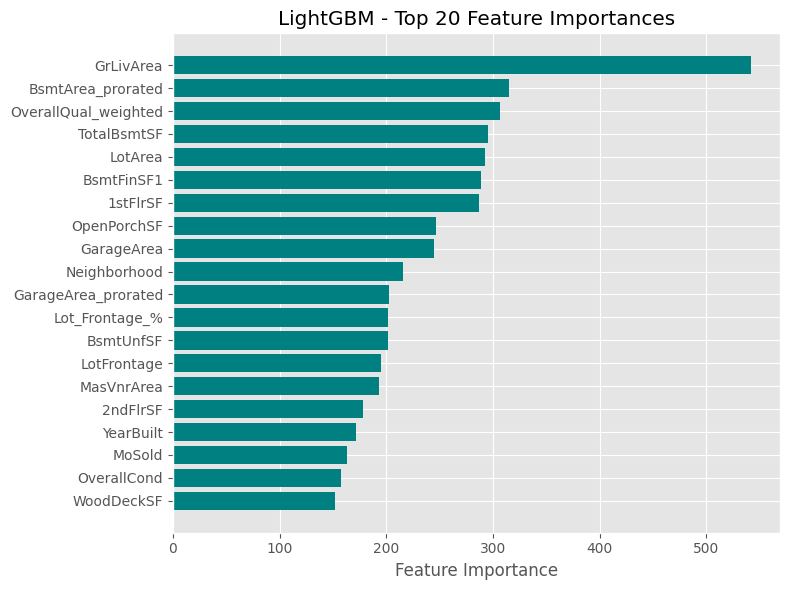

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [18]:
#LightGBM Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_lgbm, 'LightGBM', X=X2)